# Urban Street Networks and Interactive Web Maps


## Part 1: Visualizing crash data in Philadelphia

### 1.1 Load the geometry for the region being analyzed

We'll analyze crashes in the "Central" planning district in Philadelphia, a rough approximation for Center City. [Planning districts](https://www.opendataphilly.org/dataset/planning-districts) can be loaded from Open Data Philly. Read the data into a GeoDataFrame using the following link:

http://data.phl.opendata.arcgis.com/datasets/0960ea0f38f44146bb562f2b212075aa_0.geojson

In [1]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import numpy as np

In [2]:
districts = gpd.read_file("http://data.phl.opendata.arcgis.com/datasets/0960ea0f38f44146bb562f2b212075aa_0.geojson")

In [3]:
#  the selection True/False array
selection = districts['DIST_NAME'] == "Central"

# Get only Central data
boundary = districts.loc[selection]

# Extract out just the geometry
boundary = boundary.geometry.squeeze()

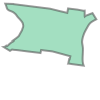

In [4]:
boundary

### 1.2 Get the street network graph

Use OSMnx to create a network graph (of type 'drive') from your polygon boundary in 1.1.

In [5]:
# get the graph
G = ox.graph_from_polygon(boundary, network_type='drive')

### 1.3 Convert your network graph edges to a GeoDataFrame

Use OSMnx to create a GeoDataFrame of the network edges in the graph object from part 1.2. The GeoDataFrame should contain the edges but not the nodes from the network.

In [6]:
# only get the edges
edges = ox.graph_to_gdfs(G, edges=True, nodes=False)

In [7]:
edges.head()

,osmid,oneway,name,highway,length,geometry,lanes,maxspeed,tunnel,bridge,ref,service,access,junction,u,v,key
0,132508434,True,Bainbridge Street,residential,44.137,"LINESTRING (-75.17104 39.94345, -75.17053 39.9...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109727439,109911666,0
1,12109011,True,South Colorado Street,residential,109.484,"LINESTRING (-75.17125 39.94248, -75.17120 39.9...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109727448,109727439,0
2,12159387,True,Fitzwater Street,residential,91.353,"LINESTRING (-75.17125 39.94248, -75.17137 39.9...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109727448,110034229,0
3,193364514,True,Carpenter Street,residential,53.208,"LINESTRING (-75.17196 39.93973, -75.17134 39.9...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109727507,110024052,0
4,672312336,True,Brown Street,residential,58.270,"LINESTRING (-75.17317 39.96951, -75.17250 39.9...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109728761,110274344,0


### 1.4 Load PennDOT crash data

Data for 2019 crashes (of all types) is available at the following path:

`./data/CRASH_2019_Philadelphia.csv`

The data was downloaded for Philadelphia County [from here](https://crashinfo.penndot.gov/PCIT/welcome.html).

In [8]:
crashes = pd.read_csv("./data/CRASH_2019_Philadelphia.csv")

In [9]:
crashes.head()

,ARRIVAL_TM,AUTOMOBILE_COUNT,BELTED_DEATH_COUNT,BELTED_SUSP_SERIOUS_INJ_COUNT,BICYCLE_COUNT,BICYCLE_DEATH_COUNT,BICYCLE_SUSP_SERIOUS_INJ_COUNT,BUS_COUNT,CHLDPAS_DEATH_COUNT,CHLDPAS_SUSP_SERIOUS_INJ_COUNT,...,WZ_CLOSE_DETOUR,WZ_FLAGGER,WZ_LAW_OFFCR_IND,WZ_LN_CLOSURE,WZ_MOVING,WZ_OTHER,WZ_SHLDER_MDN,ROADWAY_CLEARED,WEATHER1,WEATHER2
0,2035.0,2,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
1,1855.0,2,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,542.0,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,408.0,1,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
4,850.0,1,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN


### 1.5 Convert the crash data to a GeoDataFrame

In [10]:
crashes = gpd.GeoDataFrame(
    crashes,
    geometry=gpd.points_from_xy(crashes.DEC_LONG, crashes.DEC_LAT),
    crs="epsg:4326",
)

### 1.6 Trim the crash data to Center City

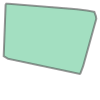

In [11]:
edges_boundary = edges.unary_union.convex_hull
edges_boundary

In [12]:
selection = crashes.within(edges_boundary)
crashes_subset = crashes.loc[selection]

In [14]:
num_crashes = len(crashes_subset)
print(f"found {num_crashes} crashes within Central district...")

found 1564 crashes within Central district...


### 1.7 Find the nearest edge for each crash

See: `ox.get_nearest_edges()`. It takes three arguments:

- the network graph
- the longitude of your crash data (the `x` attribute of the `geometry` column)
- the latitude of your crash data (the `y` attribute of the `geometry` column)

In [16]:
%%time 
nearest = ox.get_nearest_edges(G, crashes_subset.geometry.x, crashes_subset.geometry.y)

CPU times: user 5min 11s, sys: 6.3 s, total: 5min 18s
Wall time: 6min 12s


In [17]:
nearest

array([[1589900925,  109791270,          0],
       [ 109767943,  110232451,          0],
       [ 109849614,  109849604,          0],
       ...,
       [ 765755081,  110225620,          0],
       [ 110311510,  110311460,          0],
       [ 110417392,  110530981,          0]])

### 1.8 Calculate the total number of crashes per street


In [18]:
df = pd.DataFrame(nearest, columns=['u', 'v', 'key'])
counts = df.groupby(['u', 'v']).size().reset_index(name='crash_count')

In [19]:
counts.head()

,u,v,crash_count
0,109729330,110216446,2
1,109729474,3425014859,1
2,109729699,109729709,1
3,109729699,109811674,1
4,109729709,109729731,1


### 1.9 Merge your edges GeoDataFrame and crash count DataFrame


In [20]:
# Perform the merge
edges_with_crashes = edges.merge(counts, on=['u', 'v'], how='left')

# Edges that are NaN didn't have any crashes!
edges_with_crashes['crash_count'] = edges_with_crashes['crash_count'].fillna(0)

### 1.10 Calculate a "Crash Index"

Let's calculate a "crash index" that provides a normalized measure of the crash frequency per street. 

In [21]:
# Define the crash per length column
edges_with_crashes['crash_per_length'] = edges_with_crashes['crash_count'] / edges_with_crashes['length']

# Take the log of the nonzero elements
nonzero = edges_with_crashes['crash_count'] > 0

# The log of the crash index
log_count = np.log10(edges_with_crashes.loc[nonzero]['crash_per_length'])

In [22]:
# Crash index is normalized from 0 to 1
edges_with_crashes['crash_index'] = (log_count - log_count.min()) / (log_count.max() - log_count.min())

### 1.11 Plot a histogram of the crash index values

Use matplotlib's `hist()` function to plot the crash index values from the previous step.

In [23]:
from matplotlib import pyplot as plt
%matplotlib inline

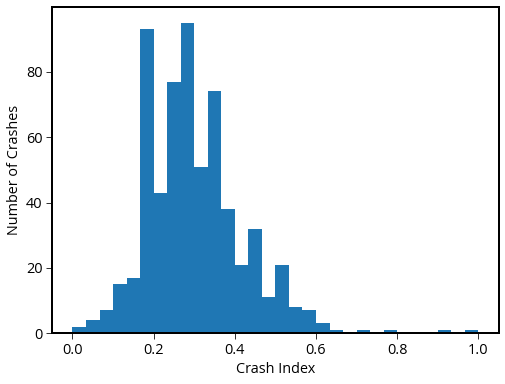

In [24]:
# Initialize the figure
fig, ax = plt.subplots(figsize=(8,6))

# Create a histogram
ax.hist(edges_with_crashes['crash_index'].dropna(), bins='auto')

# Format
ax.set_xlabel("Crash Index")
ax.set_ylabel("Number of Crashes");

### 1.12 Plot the street networks, colored by the crash index

You can use GeoPandas to make the plot, coloring the streets by the crash index column.

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

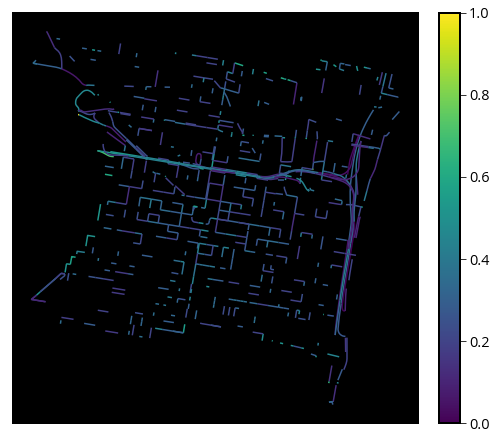

In [26]:
# Initialize 
fig, ax = plt.subplots(figsize=(8,8))

# Create a nice, lined up colorbar axes (called "cax" here)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.3)

# Plot the 
df = edges_with_crashes.to_crs(epsg=3857)
ax = df.plot(ax=ax, cax=cax, column='crash_index', cmap='viridis', legend=True)

# Format
ax.set_facecolor('black')
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect("equal")

### 1.13 An interactive map of the crash index

In this part, we'll use Folium to make an interactive version of the map from the previous section. 

1. Initialize a Folium map centered on Philadelphia. The "Cartodb dark_matter" will be best if you want to use the viridis color map.
1. Add the street edges polygons to the map using the `Folium.GeoJson()` function.
1. Use a style function that applies a color to the edge geometries based on the value of the "crash index" column. 
    - See the crash index is defined from 0 to 1, you can pass this directly to a color map object, as in lecture.
    - You will need to convert the RGB color returned by the color map to a hex string
    - You can also set the "weight" attribute to change the width of the streets.
1. Add a GeoJsonTooltip object that includes the street name and crash index value so you can quickly identify which streets have the highest index values.

In [27]:
import folium

In [28]:
import matplotlib.colors as mcolors

In [29]:
# Use a viridis cmap
cmap = plt.get_cmap("viridis")


def get_style(features):
    """
    Style the color of the geometry based on the value
    of the "crash_index" column
    """
    # Get the value of the crash index
    val = features["properties"]["crash_index"]

    # If it's None, set it to zero (no crashes)
    if val is None:
        val = 0

    # Get the color as a hex string
    rgb_color = cmap(val)
    color = mcolors.rgb2hex(rgb_color)

    # Return the style dictionary
    return {"color": color, "weight": 3}

In [30]:
# create the map
m = folium.Map(
    location=[39.95, -75.15],
    tiles='Cartodb dark_matter',
    zoom_start=13
)

# We need the geometry, name, and crash index -> convert to JSON
edges_json = edges_with_crashes[['geometry', 'name', 'crash_index']].to_json()

# add the GeoJson to the map
folium.GeoJson(
    edges_json,
    style_function=get_style,
    tooltip=folium.GeoJsonTooltip(['name', 'crash_index'])
).add_to(m)


m

### 2: Mapping out pothole 311 requests from the last 30 days

In [31]:
import carto2gpd

In [32]:
DAYS = 30 # pull for 30 days into the past

In [33]:
# The API URL
url = "https://phl.carto.com/api/v2/sql"

# The table name for the 311 dataset
# See: https://cityofphiladelphia.github.io/carto-api-explorer/#public_cases_fc
table_name = "public_cases_fc"

# Pull street defects from the last 90 days
where = f"service_name = 'Street Defect' AND requested_datetime >= current_date - {DAYS}"

# Query
features = carto2gpd.get(url, table_name, where=where)

# Remove missing geometries
features = features.loc[features.geometry.notnull()]

In [34]:
features.head()

,geometry,cartodb_id,objectid,service_request_id,status,status_notes,service_name,service_code,agency_responsible,service_notice,requested_datetime,updated_datetime,expected_datetime,address,zipcode,media_url,lat,lon
0,POINT (-75.12495 39.98601),1898424,9550006,13778691,Open,None,Street Defect,SR-ST01,Streets Department,45 Business Days,2020-11-18T14:47:35Z,2020-11-24T08:31:40Z,2021-01-28T19:00:00Z,2018 E HUNTINGDON ST,None,None,39.986009,-75.124948
1,POINT (-75.22281 39.95821),3074655,9514300,13771366,Open,None,Street Defect,SR-ST01,Streets Department,None,2020-11-13T16:26:04Z,2020-11-18T09:02:01Z,2021-01-25T19:00:00Z,5043 CHESTNUT ST,None,None,39.958210,-75.222809
2,POINT (-75.19639 40.06662),2164961,9508221,13775527,Open,None,Street Defect,SR-ST01,Streets Department,3 Business Days,2020-11-17T11:20:40Z,2020-11-17T11:31:28Z,2020-11-19T19:00:00Z,CRESHEIM VALLEY DR & GERMANTOWN AVE,None,None,40.066624,-75.196387
3,POINT (-75.18363 39.97461),2493407,9557795,13786237,Open,None,Street Defect,SR-ST01,Streets Department,46 Business Days,2020-11-23T13:02:19Z,2020-11-25T12:00:36Z,2021-02-03T19:00:00Z,2901 W GIRARD AVE,None,None,39.974614,-75.183627
4,POINT (-75.20770 40.07355),3173276,9485150,13760769,Closed,None,Street Defect,SR-ST01,Streets Department,3 Business Days,2020-11-06T13:47:31Z,2020-11-10T15:02:28Z,2020-11-10T19:00:00Z,126 W MEADE ST,None,None,40.073546,-75.207700


In [35]:
# extract the lat and longitude from the geometry column
features['lat'] = features.geometry.y
features['lng'] = features.geometry.x

# make a NumPy array (use the "values" attribute)
coordinates = features[['lat', 'lng']].values

In [36]:
from folium.plugins import HeatMap

In [37]:
m = folium.Map(
    location=[39.99, -75.13],
    tiles='Cartodb Positron',
    zoom_start=11
)


# add heat map
HeatMap(coordinates).add_to(m)

m